In [1]:
'''
Подключение всех нужных библиотек и функций
'''



import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_blobs
from sklearn.datasets import make_circles

In [2]:
'''
Функции
'''



# Начальное условие для генератора случайных чисел
np.random.seed(42)


# LaTeX
def formatted(s):
    return '$%s$' % s


# Построение графика
def graph(X, y, clf, title=''):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = clf.decision_function(xy).reshape(XX.shape)

    ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
               linewidth=1, facecolors='none', edgecolors='r')
    ax.set_title(title)
    plt.show()

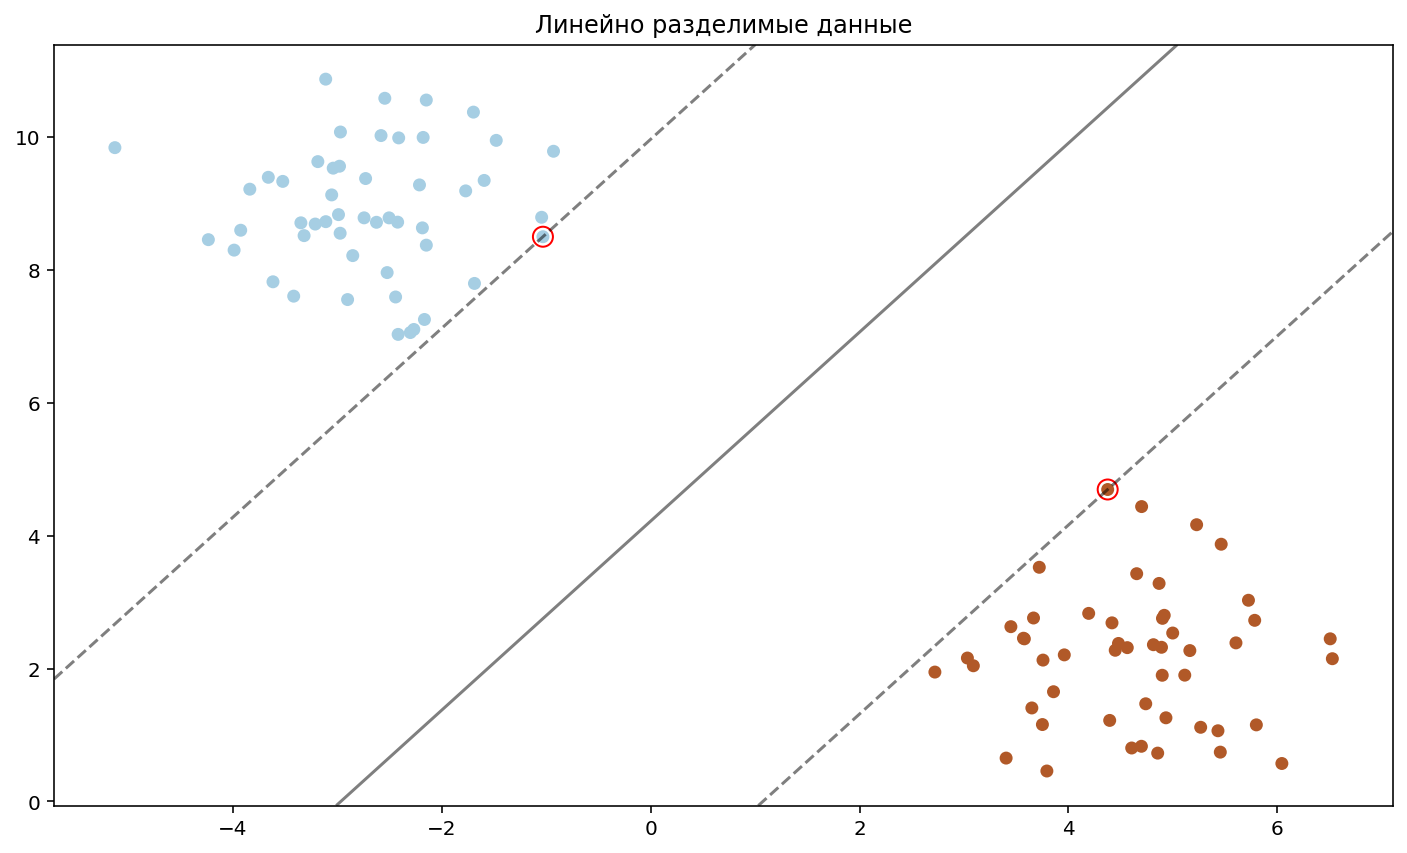

In [3]:
'''
Линейно разделимые данные
'''



# Генерация
n = 100
X, y = make_blobs(n_samples=n, centers=2, random_state=42)

# Обучение и вывод результатов
clf = SVC(kernel='linear')
clf.fit(X, y)

graph(X, y, clf, 'Линейно разделимые данные')

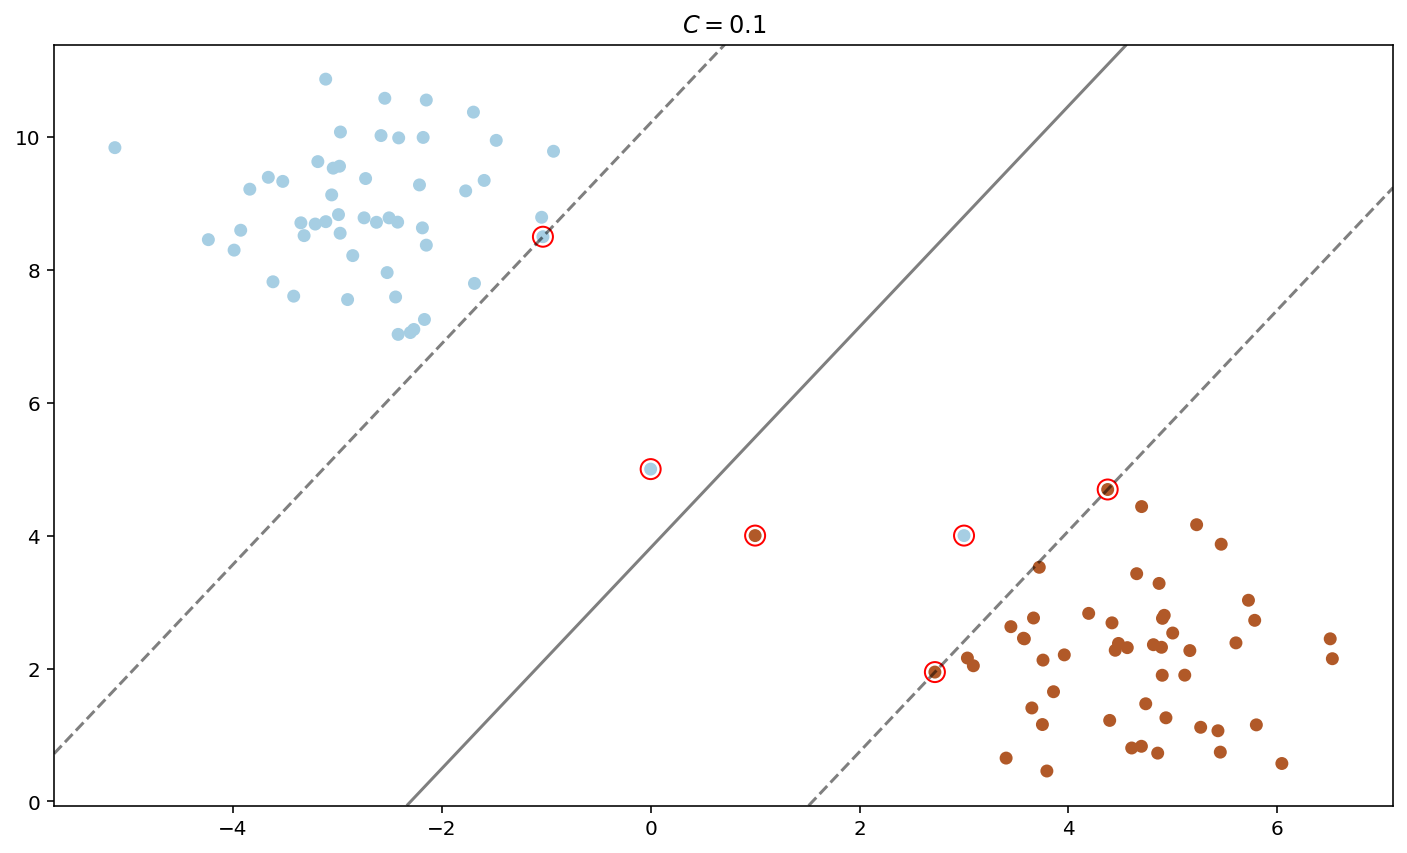

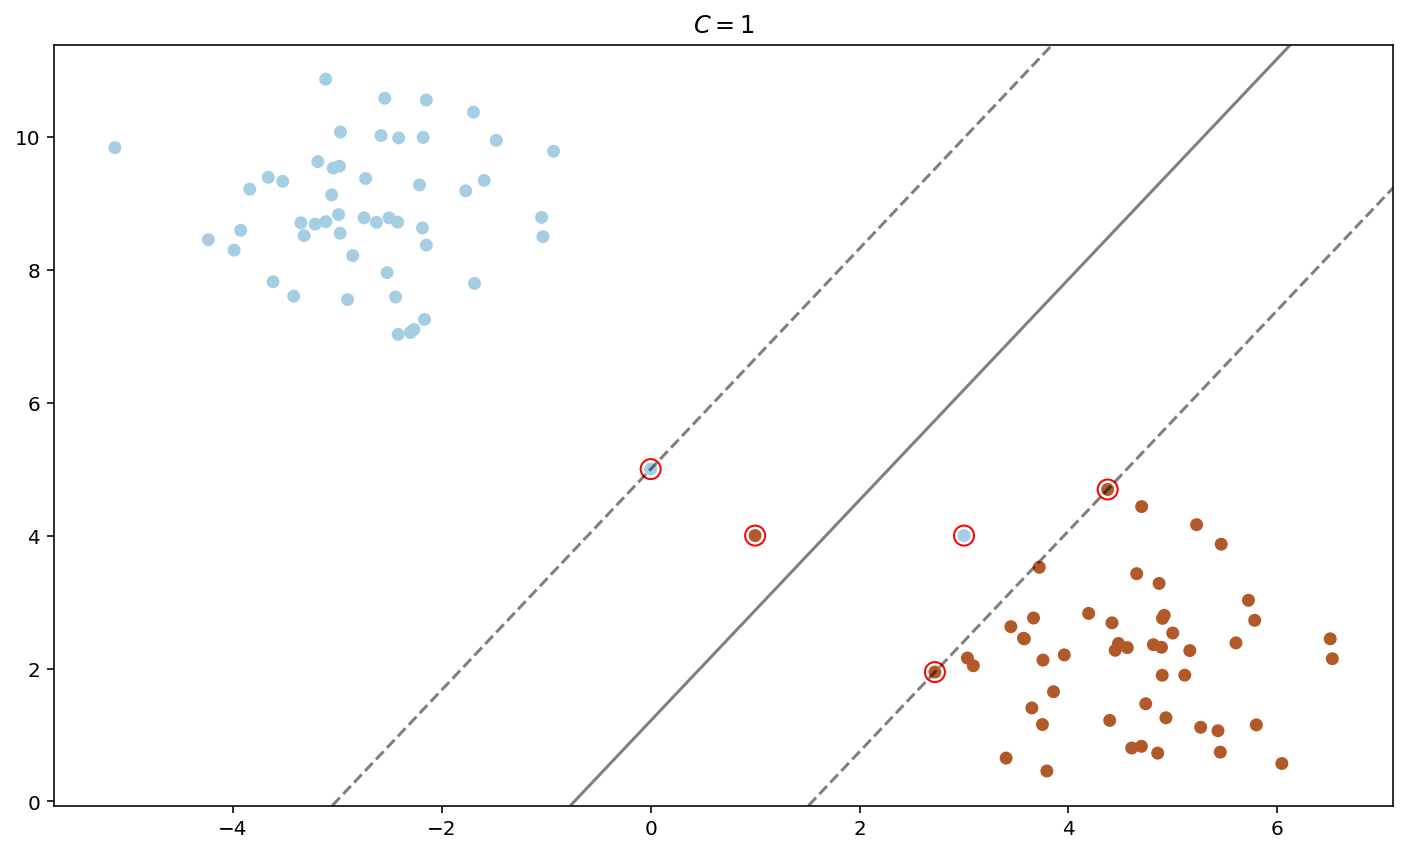

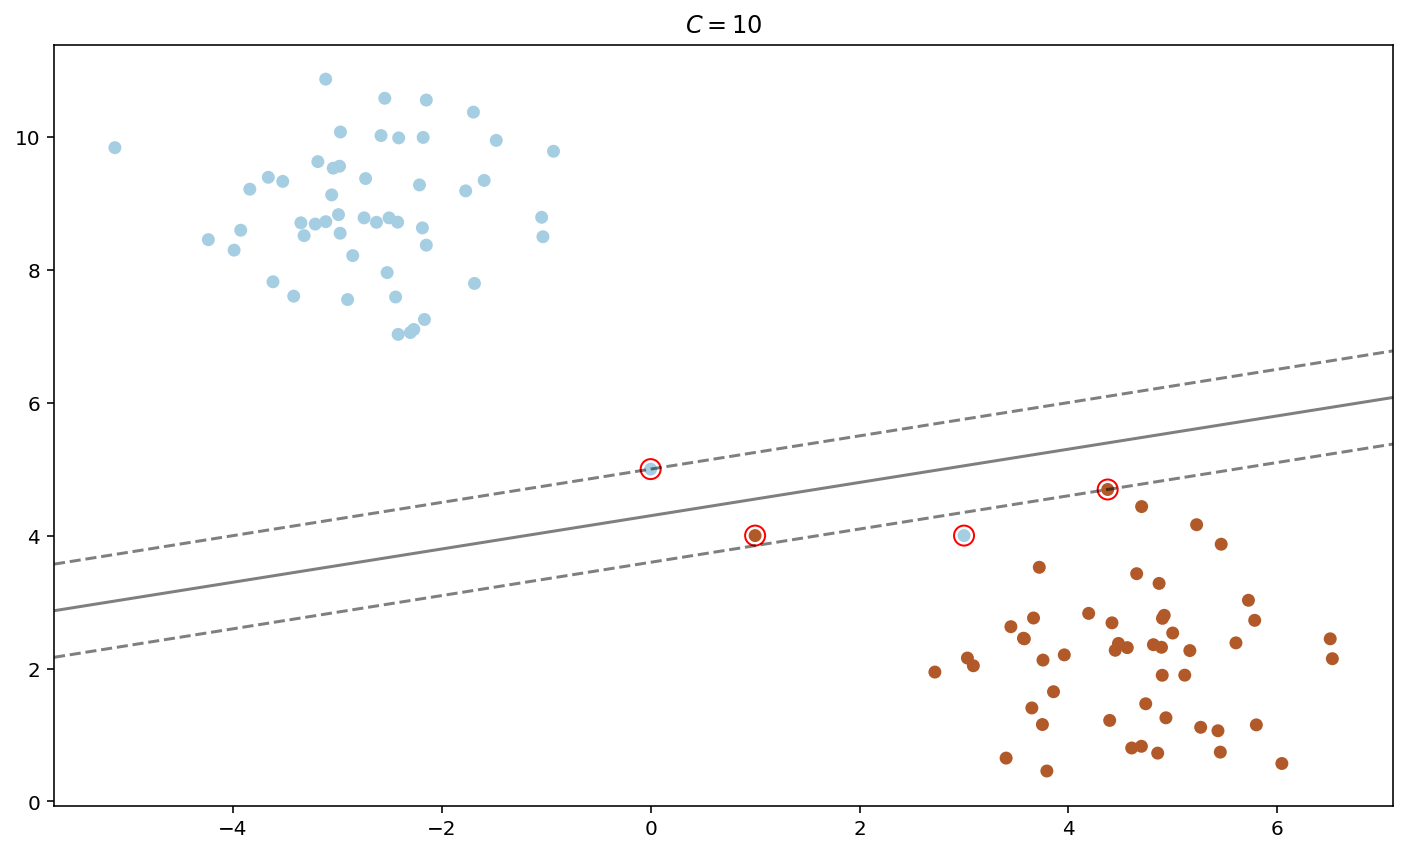

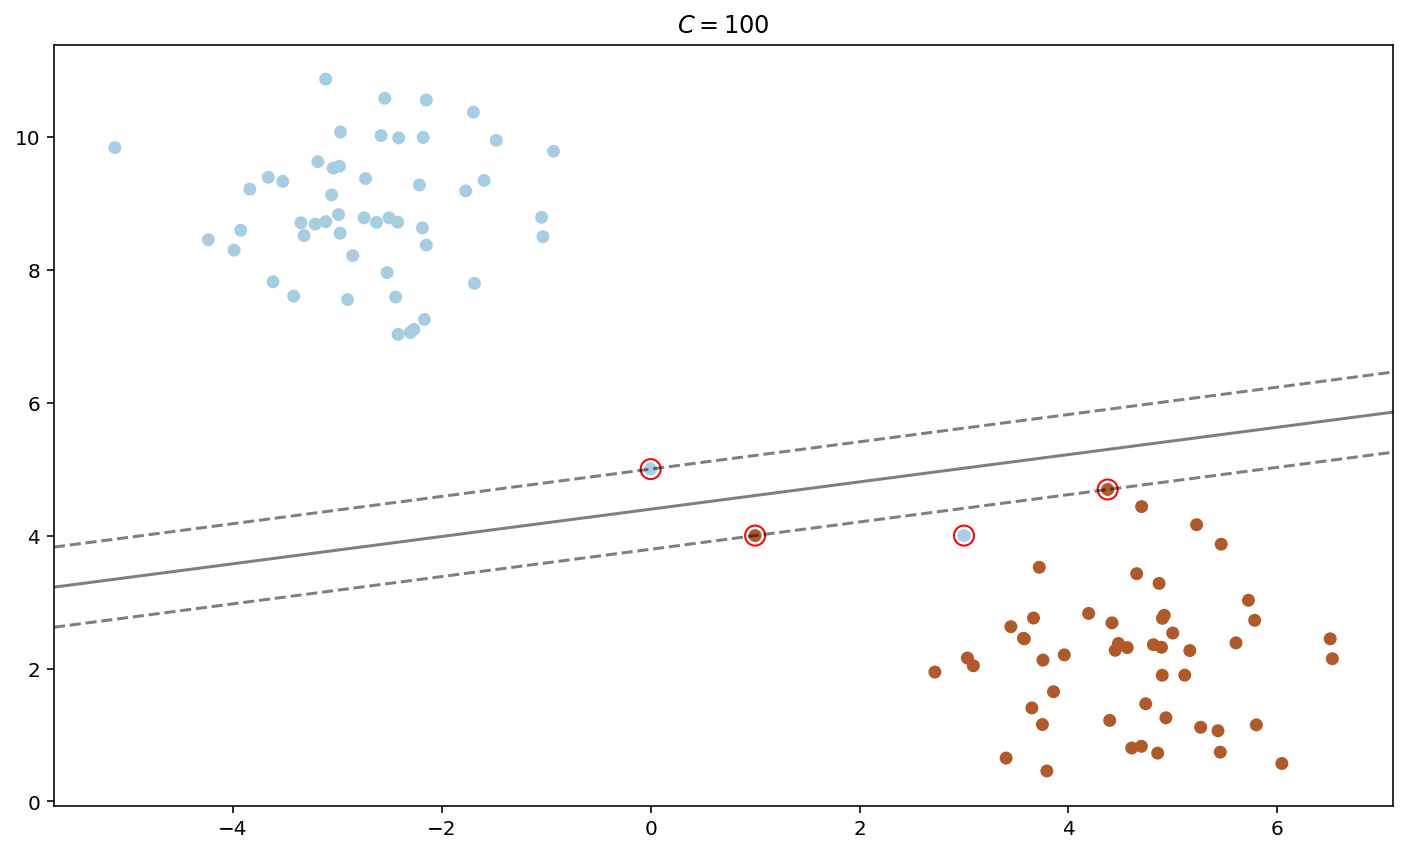

$C$,$M=\frac{1}{\left \| w \right \|}$
0.1,3.296144
1,1.952715
10,0.679880
100,0.590560


In [4]:
'''
Линейно разделимые данные с внесёнными выбросами
'''



# Генерация
n = 100
X, y = make_blobs(n_samples=n, centers=2, random_state=42)

# Внесение выбросов
outliers_X = np.array([
        [0, 5],
        [1, 4],
        [3, 4]
    ])
outliers_y = np.array([
        0,
        1,
        0
    ]).T
X = np.append(X, outliers_X, axis=0)
y = np.append(y, outliers_y, axis=0)

table = pd.DataFrame(data=[], columns=[formatted(r"M=\frac{2}{\left \| w \right \|}")])
table.columns.name = formatted(r'C')

# Исследование при различных C
for C in [0.1, 1, 10, 100]:
    clf = SVC(kernel='linear', C=C)
    clf.fit(X, y)
    norm_w = np.sqrt(np.sum(clf.coef_ ** 2))
    M = 1 / norm_w
    table.loc[str(C)] = [M]

    graph(X, y, clf, formatted('C=' + str(C)))

display(table)

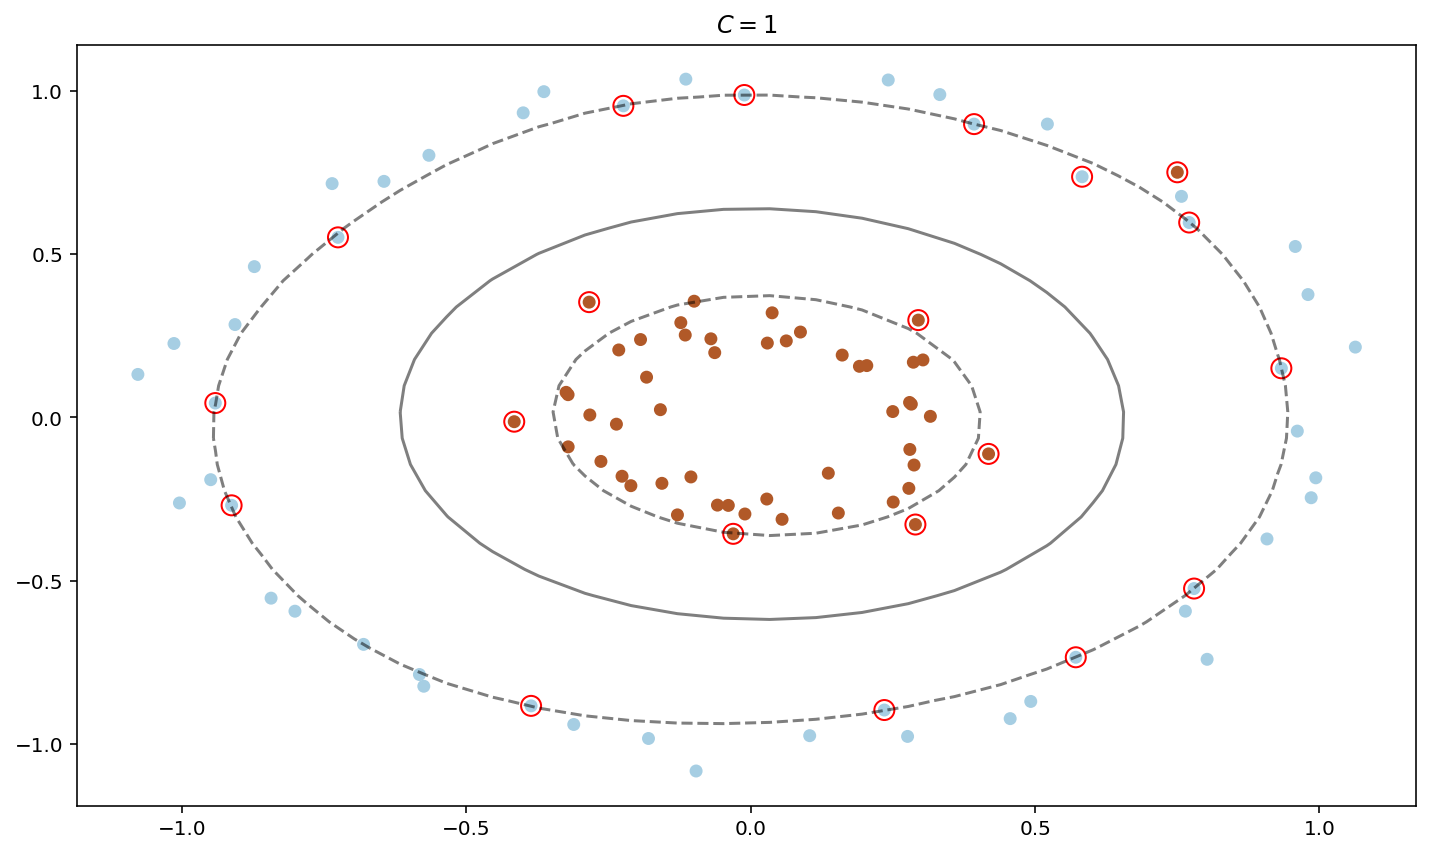

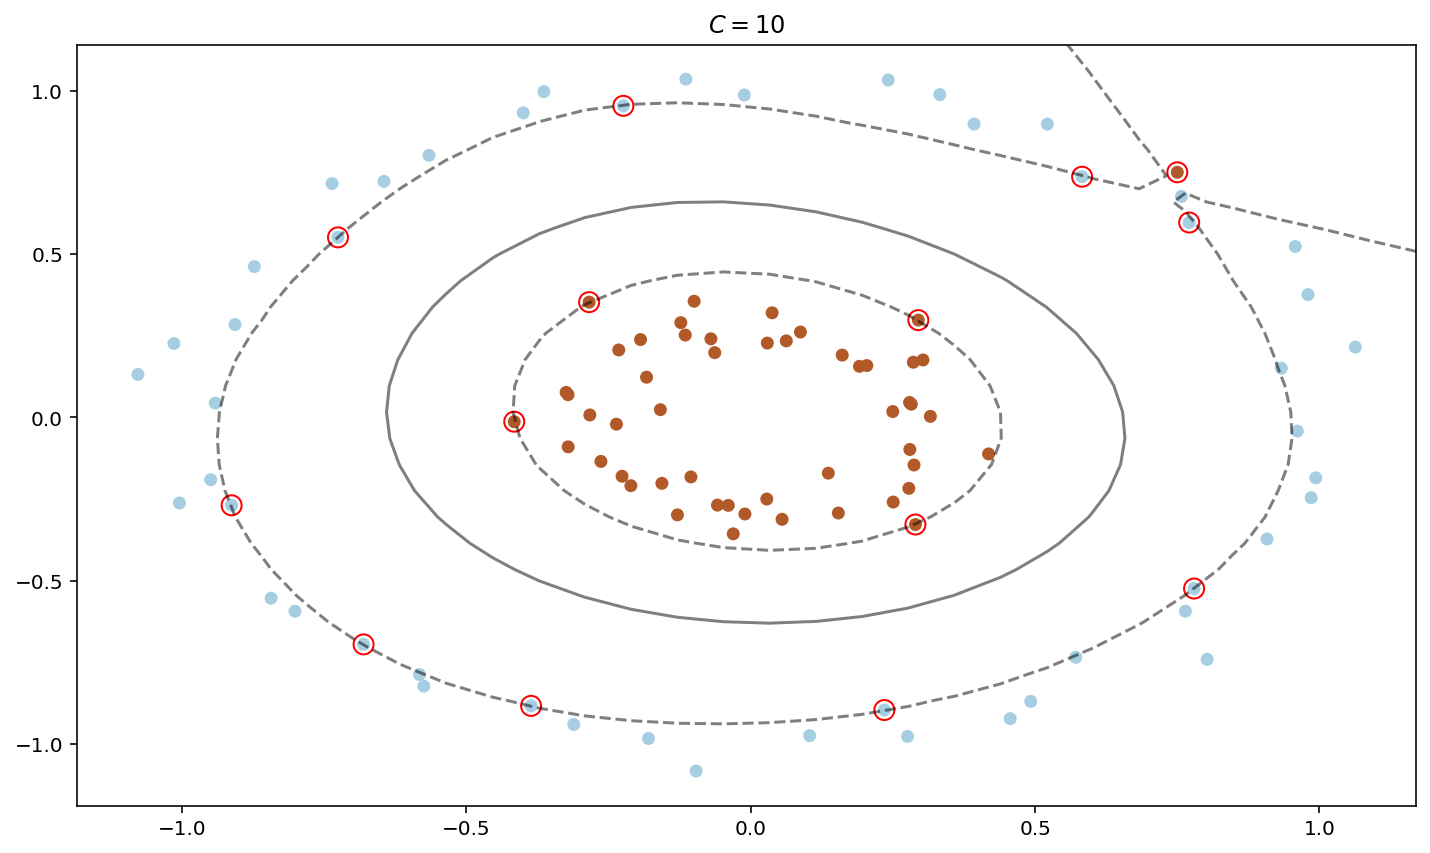

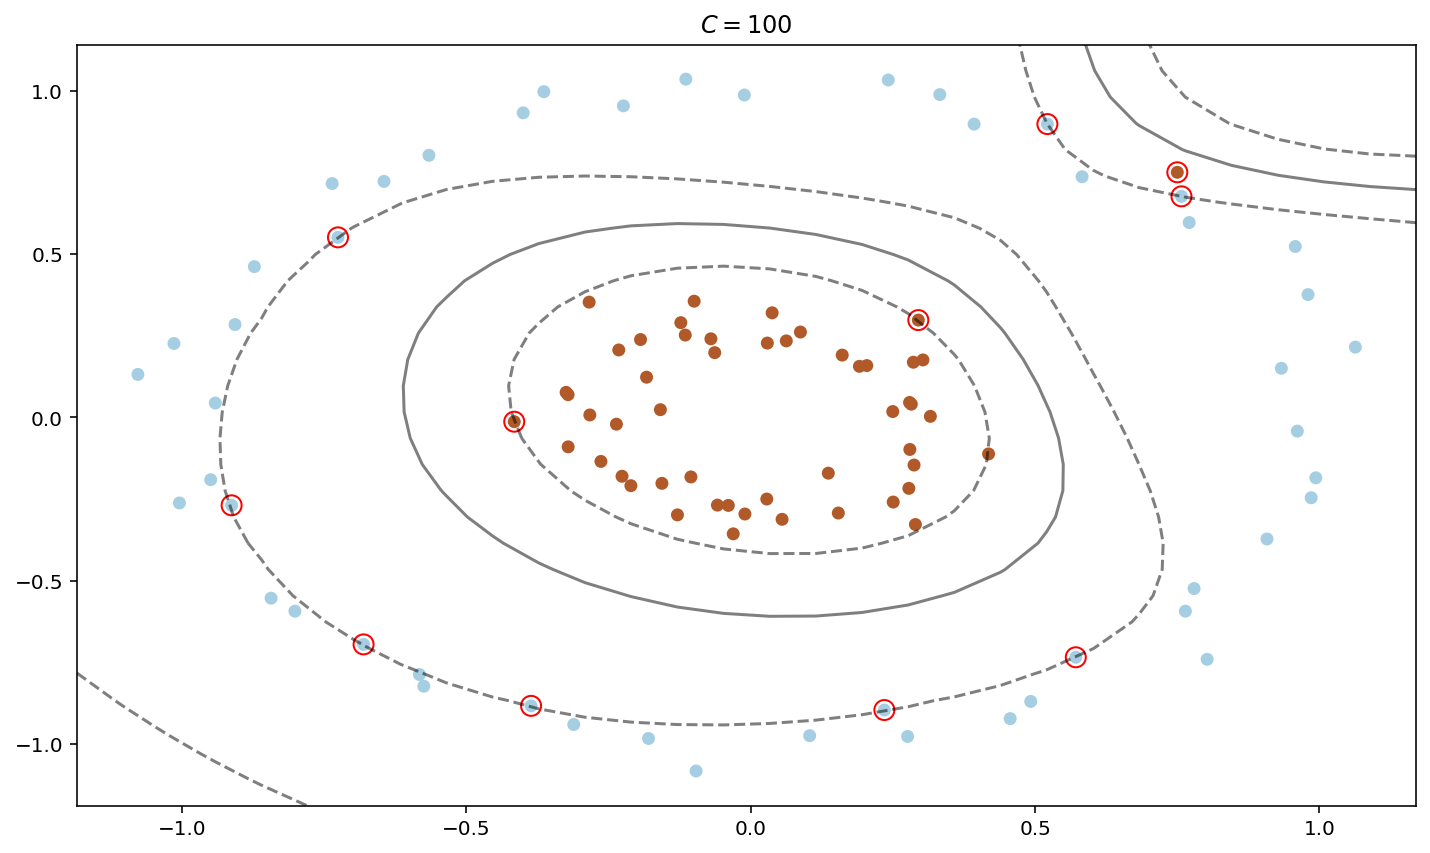

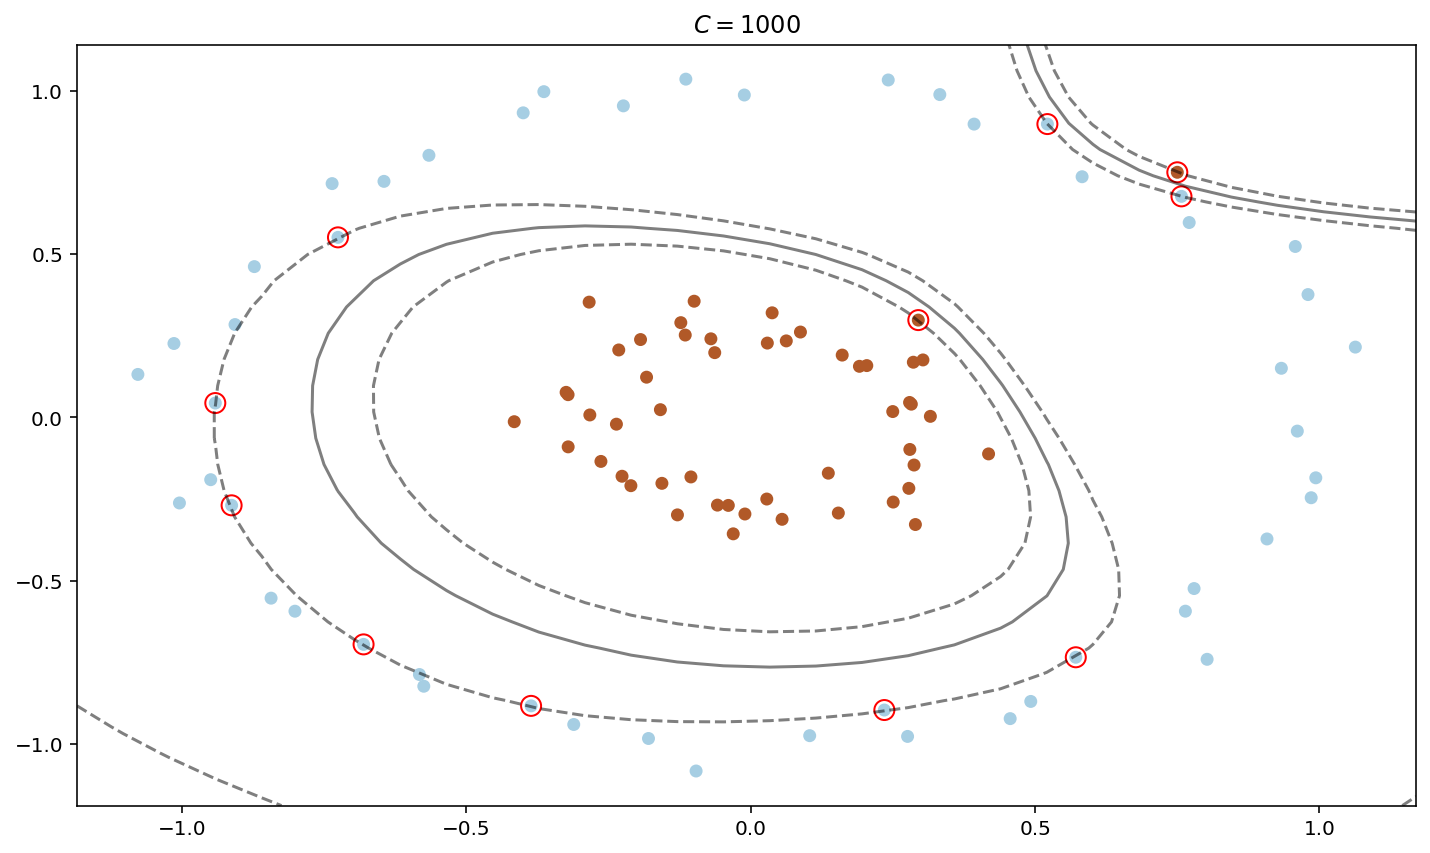

In [5]:
'''
Линейно неразделимые данные
'''



# Генерация
n = 100
X, y = make_circles(n_samples=n, factor=0.3, noise=0.05, random_state=42)

# Внесение выбросов
outliers_X = np.array([
        [0.75, 0.75]
    ])
outliers_y = np.array([
        1
    ]).T
X = np.append(X, outliers_X, axis=0)
y = np.append(y, outliers_y, axis=0)

# Исследование при различных C
for C in [1, 10, 100, 1000]:
    clf = SVC(kernel='rbf', C=C)
    clf.fit(X, y)
    
    graph(X, y, clf, formatted('C=' + str(C)))

In [6]:
'''
german
'''



# Получение и считывание данных из файла в двумерный numpy-массив
def parse_file(filename):
    arr = []

    with open(filename) as file:
        for line in file:
            arr.append(list(map(int, line.strip().split())))

    return np.array(arr)


# Исследование на сетках по C и gamma
def analyze(X, y, title=''):
    # Точность предсказания
    def get_accuracy_percent(X, y, clf):
        y_pred = clf.predict(X)
        correct_preds = 0
        
        for i in range(len(y_pred)):
            if y_pred[i] == y[i]:
                correct_preds = correct_preds + 1
        
        accuracy_percent = (correct_preds / len(y_pred)) * 100
        
        return accuracy_percent
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2, random_state=42)
    C_grid = [0.1, 1, 10, 100]
    gamma_grid = [1e-1, 1e-2, 1e-3, 1e-4]
    
    table = pd.DataFrame([], columns=gamma_grid)
    table.columns.name = formatted(r'C \backslash \gamma')
    best_C_i, best_gamma_j = 0, 0
    
    for i in range(len(C_grid)):
        C = C_grid[i]
        C_accuracies = np.array([])
        
        for j in range(len(gamma_grid)):
            gamma = gamma_grid[j]
            clf = SVC(kernel='rbf', C=C, gamma=gamma)
            clf.fit(X_train, y_train)
            C_accuracies = np.append(C_accuracies, get_accuracy_percent(X_train, y_train, clf))
        
        table.loc[C] = C_accuracies
        j_max = np.argmax(C_accuracies)
        
        if C_accuracies[j_max] > table.loc[C_grid[best_C_i], gamma_grid[best_gamma_j]]:
            best_C_i, best_gamma_j = i, j_max

    best_C, best_gamma = C_grid[best_C_i], gamma_grid[best_gamma_j]
    clf = SVC(kernel='rbf', C=best_C, gamma=best_gamma)
    clf.fit(X_train, y_train)
    accuracy_percent_train = table.loc[best_C, best_gamma]
    accuracy_percent_test = get_accuracy_percent(X_test, y_test, clf)
    
    print('*** ' + title + ' ***')
    print()
    display(table)
    print('Лучшая точность на обучающей выборке:', accuracy_percent_train, '%')
    print('C =', best_C)
    print('γ =', best_gamma)
    print()
    print('Точность на тестовой выборке:', accuracy_percent_test, '%')
    print()
    print()

    
# Чтение и преобразование данных в numpy-массивы
german = parse_file('german.data-numeric')
X, y = german[:, :-1], german[:, -1] - 1

# На полном наборе признаков
analyze(X, y, 'На полном наборе признаков')

# По трём главным компонентам
pca = PCA(n_components=3)
PCA_X = pca.fit_transform(X)

analyze(PCA_X, y, 'По трём главным компонентам')

var_percents = pca.explained_variance_ratio_ * 100
print('% дисперсии первых 3-х главных компонент:', var_percents)
print('Суммарно:', np.sum(var_percents), '%')
print()

*** На полном наборе признаков ***



$C \backslash \gamma$,0.1000,0.0100,0.0010,0.0001
0.1,70.125,70.125,70.125,70.125
1.0,99.250,83.375,72.875,71.250
10.0,100.000,97.250,83.000,72.500
100.0,100.000,99.875,88.125,80.000


Лучшая точность на обучающей выборке: 100.0 %
C = 10
γ = 0.1

Точность на тестовой выборке: 70.0 %




*** По трём главным компонентам ***



$C \backslash \gamma$,0.1000,0.0100,0.0010,0.0001
0.1,70.125,70.125,70.125,70.125
1.0,88.625,77.250,72.500,71.125
10.0,95.375,82.500,74.875,71.625
100.0,97.875,87.375,75.625,71.750


Лучшая точность на обучающей выборке: 97.875 %
C = 100
γ = 0.1

Точность на тестовой выборке: 64.0 %


% дисперсии первых 3-х главных компонент: [79.42693195 12.05481689  7.46295661]
Суммарно: 98.94470544277776 %

